In [1]:
import os
import time
import requests
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
import copy

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

from tqdm.notebook import tqdm

from glob import glob
from collections import defaultdict

import importlib

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

# set num workers for loading data
NUM_WORKERS = 8

Running on device: CUDA


In [2]:
# downloading and transforming MNIST

MNIST_MEAN = (0.1307, )
MNIST_STD = (0.3081, )

mnist_transform = transforms.Compose([transforms.ToTensor(),  # this will normalize each within [0, 1]
                                transforms.Normalize(MNIST_MEAN, MNIST_STD)]) # make data have mean 0 and std 1

MNIST_BATCH_SIZE = 256

mnist_train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=MNIST_BATCH_SIZE, shuffle=True)

mnist_test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set, batch_size=MNIST_BATCH_SIZE, shuffle=False)

# Initialize a dictionary to store images for each class
mnist_class_images = defaultdict(list)

# Iterate over the dataset and store images by class
for image, label in mnist_train_set:
    mnist_class_images[label].append(image.clone()) # remember to clone it

In [3]:
# define image denormalizer
def denormalize(tensor: torch.Tensor, mean, std):
    """
    tensor can have multiple channels.
    In such case, mean and std should be lists with the same length as the channel number
    """
    # clone the tensor to avoid changes to the original data
    tensor = tensor.clone()
    # denormalize each channel
    for t, m, s in zip(tensor, mean, std):
        t = t.mul(s).add(m)  # out-of-place operation
    # clamp the values to ensure they're within [0, 1] range
    return tensor.clamp(0, 1)

MNIST image shape: torch.Size([1, 28, 28])


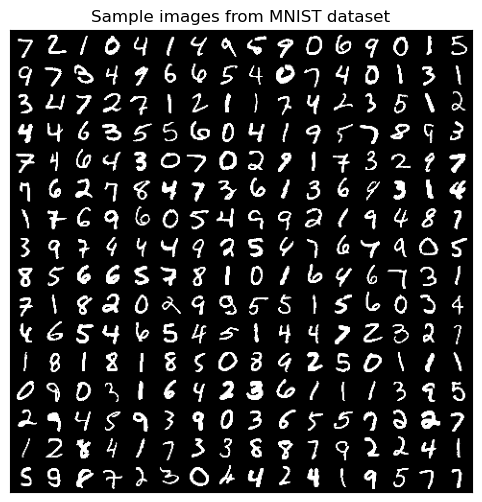

In [4]:
# print some images from MNIST just for fun
images, labels = next(iter(mnist_test_loader))
mnist_img_shape = images.shape[1:]
print(f"MNIST image shape: {mnist_img_shape}")

# denormalizing the images
images = denormalize(images, MNIST_MEAN, MNIST_STD)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from MNIST dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

In [12]:
# define networks

# define LeNet for MNIST distillation
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)  # 1 input channel (grayscale), 6 output channels, 5x5 square convolution
        self.pool = nn.MaxPool2d(2, 2)   # Max pooling over a (2, 2) window
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 16*4*4 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 output classes for MNIST (digits 0-9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# define get_net
def get_net(name, init):
    if name == "lenet":
        net = LeNet()
    else:
        raise NotImplementedError()
    if init is None:
        pass
    elif init == "kaiming":
        for m in net.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    else:
        raise NotImplementedError()
    return net


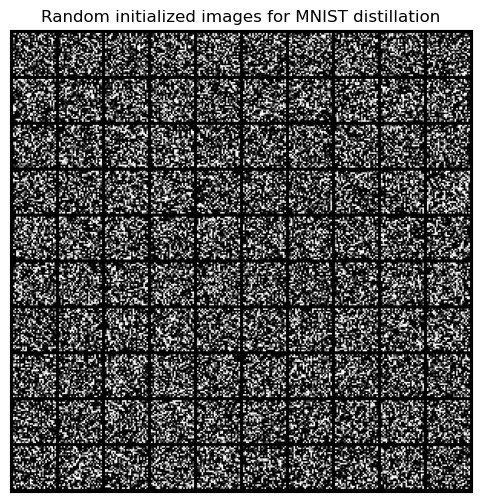

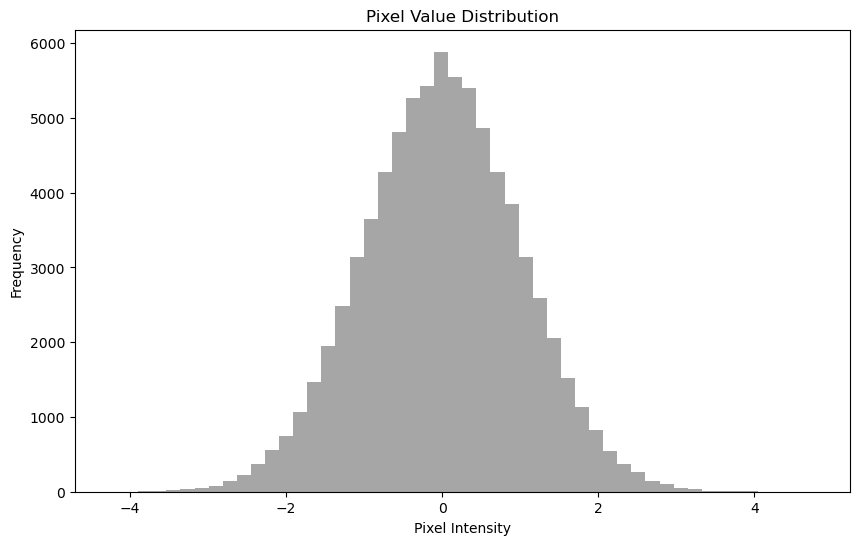

In [8]:
# define synthetic MNIST dataset
NUM_SAMPLES_PER_CLS = 10
FROM_REAL_SAMPLES = False

num_cls_mnist = 10

# initialize random synth dataset
if not FROM_REAL_SAMPLES:
    mnist_img_syn = torch.randn(size=(num_cls_mnist*NUM_SAMPLES_PER_CLS, *mnist_img_shape), dtype=torch.float, requires_grad=True, device=DEVICE)
    mnist_lab_syn = torch.tensor(np.array([np.ones(NUM_SAMPLES_PER_CLS)*i for i in range(num_cls_mnist)]), dtype=torch.long, requires_grad=False, device=DEVICE).view(-1)
else:
    # Randomly sample images from each class
    sampled_images = {cls: random.sample(images, NUM_SAMPLES_PER_CLS) for cls, images in mnist_class_images.items() if len(images) >= NUM_SAMPLES_PER_CLS}
    assert len(sampled_images) == num_cls_mnist
    image_tensors = []
    label_tensors = []
    for label in sorted(sampled_images.keys()):
        images = sampled_images[label]
        # Stack all images for this class into a single tensor and add to the list
        image_tensors.append(torch.stack(images))
        # Create a tensor of labels for this class and add to the list
        labels = torch.full((len(images),), label, dtype=torch.long)
        label_tensors.append(labels)
    # Concatenate all class tensors to form the dataset
    mnist_img_syn = torch.cat(image_tensors).to(DEVICE)
    mnist_lab_syn = torch.cat(label_tensors).to(DEVICE)
    # Reshape the image tensor to match the required shape
    mnist_img_syn = mnist_img_syn.view(-1, *mnist_img_shape)
    # require grad for mnist_img_syn
    mnist_img_syn.requires_grad_(True)

# denormalizing the images
images = denormalize(mnist_img_syn, MNIST_MEAN, MNIST_STD).cpu()
# print some of them
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Random initialized images for MNIST distillation")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
plt.show()

# plot pixel distributions
# Convert img_syn to a numpy array if it's not already
img_syn_np = mnist_img_syn.detach().cpu().numpy()
# Reshape the array to a 1D array for histogram plotting
pixels = img_syn_np.reshape(-1)
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(pixels, bins=50, color='gray', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
# Show the plot
plt.show()

In [11]:
# define training util fuctions

def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    # compare with the true labels and count the correct ones
    correct = (predicted == labels).sum().item()
    # calculate the accuracy
    acc = correct / labels.size(0)
    return acc

def overall_accuracy(net, dataloader):
    net.eval()
    device = next(net.parameters()).device
    sum_acc = 0
    sum_w = 0
    with torch.no_grad():
        for i, (imgs, labs) in enumerate(dataloader):
            outputs = net(imgs.to(device))
            local_acc = accuracy(outputs, labs.to(device))
            sum_acc += local_acc * len(imgs)
            sum_w += len(imgs)
    return sum_acc / sum_w

In [ ]:
# code for distilling dataset

# vanilla Dataset Distillation intends to get dataset that is able to train a model within only 1 epoch

DATASET = ["mnist", "cifar10"][0]

# define hyper params
NUM_OPTIM_IT = 100000
EVAL_INTERVAL = 1000

INIT_LR = 0.001
MINIMUM_LR = 1e-5
STEP_SIZE = 0.001
INIT_WEIGHTS_DISTR = [None, "kaiming"][1]
FIX_INIT_WEIGHTS = False
NUM_SAMPLED_NETS_TRAIN = 16
NUM_SAMPLED_NETS_EVAL = 4 # only when FIX_INIT_WEIGHTS is False

# checkpoints saving
CHECKPOINT_SAVE_DIR = "./saved_data/imgdd/"
if not os.path.exists(CHECKPOINT_SAVE_DIR):
    os.makedirs(CHECKPOINT_SAVE_DIR)

# define local variables
if DATASET == "mnist":
    train_loader = mnist_train_loader
    test_loader = mnist_test_loader
    img_syn = mnist_img_syn
    lab_syn = mnist_lab_syn
    net_name = "lenet"
    pixel_mean, pixel_std = MNIST_MEAN, MNIST_STD
else:
    raise NotImplementedError()

# initialize learning rate
lr = torch.tensor([INIT_LR], dtype=torch.float, requires_grad=True, device=DEVICE) # make it learnable

optimizer_img = torch.optim.Adam([img_syn], lr=STEP_SIZE)
optimizer_lr = torch.optim.Adam([lr], lr=STEP_SIZE)

loss_fn = torch.nn.CrossEntropyLoss()

# data used for plotting curves
optim_losses = [] # optimization objective loss each iteration
min_optim_loss = float('inf')
learned_lrs = [] # synthetic lr
eval_accs_train = [] # evaluation accuracy on train set
eval_accs_test = [] # evaluation accuracy on test set

# begin training steps
pbar = tqdm(range(NUM_OPTIM_IT), desc="Distilling dataset using vanilla DD")

train_loader_iter = iter(train_loader)

for it in pbar:
    # get a minibatch of real training data
    try:
        img_real, lab_real = next(train_loader_iter)
    except StopIteration:
        # End of DataLoader reached, reinitialize the iterator
        train_loader_iter = iter(train_loader)
        img_real, lab_real = next(train_loader_iter)
    
    img_real, lab_real = img_real.to(DEVICE), lab_real.to(DEVICE)

    # evaluate the distilled data every `EVAL_INTERVAL` iterations
    if EVAL_INTERVAL > 0 and it % EVAL_INTERVAL == 0:
        print(f"Optimization iteration {it} evaluation begins...")
        img_syn_checkpoint = img_syn.detach().clone()
        # lab_syn are not learning objectives so just use it in-place
        lr_checkpoint = lr.detach().clone()

        # print the images
        images = denormalize(img_syn_checkpoint, pixel_mean, pixel_std).cpu()
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.title(f"Synthetic dataset (optimization iteration {it})")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        plt.show()

        # sample a batch of models to eval on
        sampled_nets = []
        local_train_accs = []
        local_test_accs = []
        for j in range(NUM_SAMPLED_NETS_EVAL if not FIX_INIT_WEIGHTS else 1):
            if FIX_INIT_WEIGHTS:
                torch.random.manual_seed(42) # fixed seed
            else:
                torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
            net = get_net(net_name, INIT_WEIGHTS_DISTR).to(DEVICE)
            sampled_nets.append(net)
        for net in sampled_nets:
            net.train()
            optimizer = torch.optim.SGD(net.parameters(), lr=lr_checkpoint.item())
            # train the models on synthetic set
            pred_syn = net(img_syn_checkpoint)
            loss_syn = loss_fn(pred_syn, lab_syn)
            optimizer.zero_grad()
            loss_syn.backward()
            optimizer.step()
        for net in sampled_nets:
            # evaluate the models on both full train set and test set
            train_acc = overall_accuracy(net, train_loader)
            test_acc = overall_accuracy(net, test_loader)
            local_train_accs.append(train_acc)
            local_test_accs.append(test_acc)
        eval_accs_train.append(sum(local_train_accs) / len(local_train_accs))
        eval_accs_test.append(sum(local_test_accs) / len(local_test_accs))
        print(f"Optimization iteration {it}, eval acc (train): {eval_accs_train[-1]:.4f}, eval acc (test): {eval_accs_test[-1]:.4f}")
    
    # sample a batch of models
    sampled_nets = []
    for j in range(NUM_SAMPLED_NETS_TRAIN):
        if FIX_INIT_WEIGHTS:
            torch.random.manual_seed(42) # fixed seed
        else:
            torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
        net = get_net(net_name, INIT_WEIGHTS_DISTR).to(DEVICE)
        sampled_nets.append(net)
        
    optimizer_img.zero_grad()
    optimizer_lr.zero_grad()

    losses = []
    for net in sampled_nets:
        # Step 1: Train each sampled model on synthetic dataset
        net.train()
        pred_syn = net(img_syn)
        loss_syn = loss_fn(pred_syn, lab_syn)
        
        for m in net.modules():
            param_names = []
            new_params = []
            for n, p in m.named_parameters(recurse=False): # n is the param's name alone instead of "module.name"
                gp, = torch.autograd.grad(loss_syn, p, create_graph=True) # enabling higher-order derivatives
                new_p = p - lr * gp
                new_p.to(DEVICE)
                param_names.append(n) # save them, to delete leaf params later in another enumeration
                new_params.append(new_p) # save them, to reset non-leaf params later in another enumeration
            for i, n in enumerate(param_names):
                delattr(m, n)
                setattr(m, n, new_params[i])

        # Step 2: Evaluate the objective function on real training data
        pred_real = net(img_real)
        loss_real = loss_fn(pred_real, lab_real)
        losses.append(loss_real)

        # Clear gradients for the next model
        net.zero_grad()

    # Check if params are swapped as non-leaves
    # for model in sampled_models:
    #     for m in model.modules():
    #         for n, p in m.named_parameters(recurse=False): # name is the param's name alone instead of module.name
    #             print(p.grad_fn)
    
    # Step 3: Update synthetic data and learnable learning rate
    total_loss = sum(losses)
    total_loss.backward()  # Compute gradients based on real data losses

    # Update synthetic data and learning rate
    # print(lr.grad) # shouldn't be none
    # print(img_syn.grad) # shouldn't be none
    optimizer_img.step()
    optimizer_lr.step()

    # lr can't be negative
    if lr.item() < MINIMUM_LR:
        lr.data.clamp_(min=MINIMUM_LR)

    # Logging the progress
    pbar.set_postfix({"loss": f"{total_loss.item():.4f}",
                      "learnable lr": f"{lr.item()}",
                      })
    optim_losses.append(total_loss.item())
    learned_lrs.append(lr.item())

    if total_loss.item() < min_optim_loss or it >= NUM_OPTIM_IT - 1:
        min_optim_loss = total_loss.item()
        print(f"New best at iteration {it}!")
    
    checkpoint = {
        "dataset": DATASET,
        "method": "vanilla",
        "it": it,
        "img_syn": img_syn.detach().clone(),
        "lab_syn": lab_syn.detach().clone(),
        'optim_losses': optim_losses,
        'learned_lrs': learned_lrs,
        'eval_accs_train': eval_accs_train,
        'eval_accs_test': eval_accs_test,
        'init_weight_distr': INIT_WEIGHTS_DISTR,
        'fix_init_weights': FIX_INIT_WEIGHTS,
    }
    # Save checkpoint
    filepath = os.path.join(CHECKPOINT_SAVE_DIR, f'vanilla_{DATASET}_{"fiw" if FIX_INIT_WEIGHTS else "riw"}.pth')
    torch.save(checkpoint, filepath)
    print(f"Checkpoint at iteration {it} saved at {filepath}")
    

Ready for training


Training iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

Optimization iteration 0 evaluation begins...


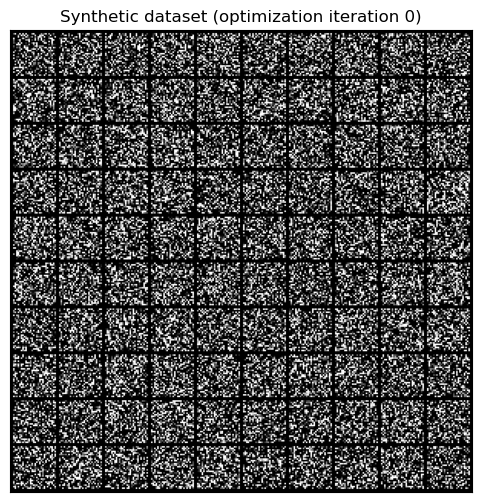

Optimization iteration 0, eval acc (train): 0.0943, eval acc (test): 0.0954
New best at iteratoin 0!
Checkpoint at iteration 0 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
New best at iteratoin 1!
Checkpoint at iteration 1 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 2 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
New best at iteratoin 3!
Checkpoint at iteration 3 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 4 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 5 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
New best at iteratoin 6!
Checkpoint at iteration 6 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 7 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
New best at iteratoin 8!
Checkpoint at iteration 8 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 9 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 10 saved at ./saved_data/

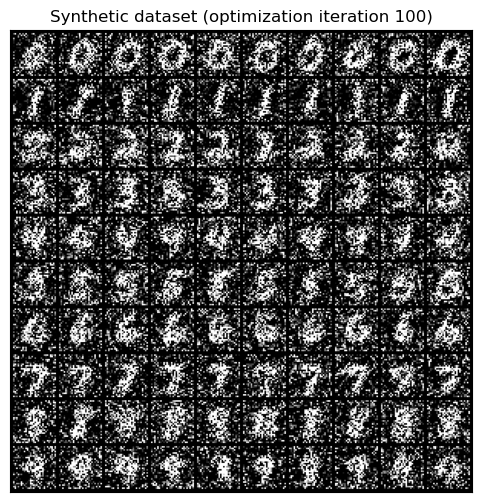

Optimization iteration 100, eval acc (train): 0.1003, eval acc (test): 0.0997
Checkpoint at iteration 100 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 101 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 102 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 103 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 104 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 105 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 106 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 107 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
New best at iteratoin 108!
Checkpoint at iteration 108 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 109 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 110 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 111 saved at ./saved_dat

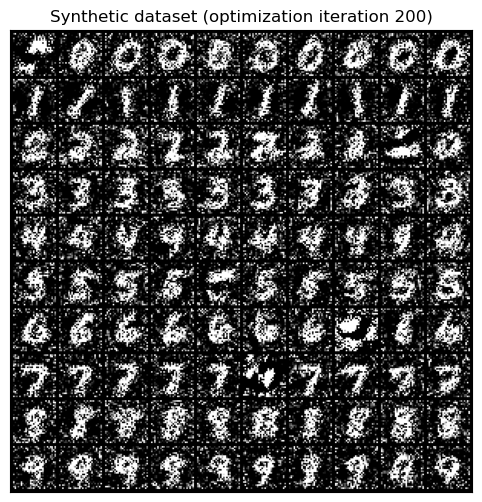

Optimization iteration 200, eval acc (train): 0.1305, eval acc (test): 0.1299
Checkpoint at iteration 200 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 201 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 202 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 203 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 204 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 205 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
New best at iteratoin 206!
Checkpoint at iteration 206 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 207 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
New best at iteratoin 208!
Checkpoint at iteration 208 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 209 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iteration 210 saved at ./saved_data/imgdd/gmatch_mnist_riw.pth
Checkpoint at iterati

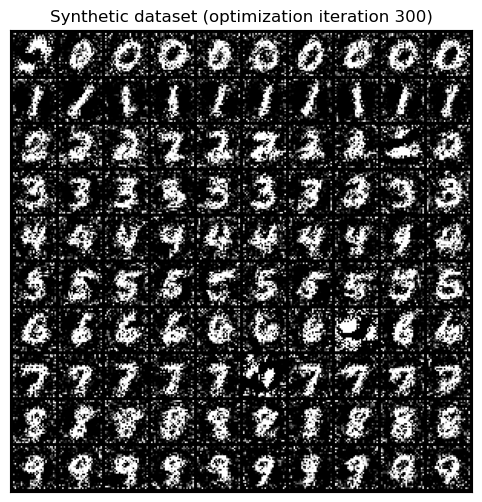

KeyboardInterrupt: 

In [13]:
# distill with gradient matching

DATASET = ["mnist", "cifar10"][0]

# define local variables
if DATASET == "mnist":
    train_loader = mnist_train_loader
    test_loader = mnist_test_loader
    img_syn = mnist_img_syn
    lab_syn = mnist_lab_syn
    net_name = "lenet"
    pixel_mean, pixel_std = MNIST_MEAN, MNIST_STD
    num_cls = num_cls_mnist
    class_images = mnist_class_images
else:
    raise NotImplementedError()

# define hyper params
NUM_OUTER_LOOPS = 1000
EVAL_INTERVAL = 100
NUM_EVAL_EPOCHS = 1000
NUM_SAMPLED_NETS_EVAL = 4
LR_DATA = 0.1 # original: 0.1
LR_NET = 0.01 # original: 0.01
NUM_INNER_LOOPS = 10
NUM_UPDT_STEPS_DATA = 1 # s_S
NUM_UPDT_STEPS_NET = 50 # s_theta
BATCH_SIZE_REAL = 256
BATCH_SIZE_SYN = 256

INIT_WEIGHTS_DISTR = [None, "kaiming"][0]
FIX_INIT_WEIGHTS = False

CLAMP_AFTER_EACH_IT = False

MATCH_LOSS = ["gmatch", "mse", "cos"][0]

# define training optimizers and criterion
optimizer_img = torch.optim.SGD([img_syn,], lr=LR_DATA, momentum=0.5) # optimizer for synthetic data
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss()
print("Ready for training")

# data for plotting curves
eval_accs_train = [] # evaluation accuracy on train set
eval_accs_test = [] # evaluation accuracy on test set
avg_losses = []
min_avg_loss = float('inf')

# checkpoints saving
CHECKPOINT_SAVE_DIR = "./saved_data/imgdd/"
if not os.path.exists(CHECKPOINT_SAVE_DIR):
    os.makedirs(CHECKPOINT_SAVE_DIR)

# proposed match loss distance
def distance_wb(gwr, gws):
    shape = gwr.shape
    if len(shape) == 4: # conv, out*in*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2] * shape[3])
        gws = gws.reshape(shape[0], shape[1] * shape[2] * shape[3])
    elif len(shape) == 3:  # layernorm, C*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2])
        gws = gws.reshape(shape[0], shape[1] * shape[2])
    elif len(shape) == 2: # linear, out*in
        tmp = 'do nothing'
    elif len(shape) == 1: # batchnorm/instancenorm, C; groupnorm x, bias
        gwr = gwr.reshape(1, shape[0])
        gws = gws.reshape(1, shape[0])
        return torch.tensor(0, dtype=torch.float, device=gwr.device)

    dis_weight = torch.sum(1 - torch.sum(gwr * gws, dim=-1) / (torch.norm(gwr, dim=-1) * torch.norm(gws, dim=-1) + 0.000001))
    dis = dis_weight
    return dis
    
pbar = tqdm(range(NUM_OUTER_LOOPS), desc="Training iteration")
for it in pbar:

    # evaluate the distilled data every `EVAL_INTERVAL` iterations
    if EVAL_INTERVAL > 0 and it % EVAL_INTERVAL == 0:
        print(f"Optimization iteration {it} evaluation begins...")
        img_syn_checkpoint = img_syn.detach().clone()
        img_syn_checkpoint.clamp_(-1, 1)
        # print the images
        images = denormalize(img_syn_checkpoint, pixel_mean, pixel_std).cpu()
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.title(f"Synthetic dataset (optimization iteration {it})")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        plt.show()

        # sample a batch of models to eval on
        sampled_nets = []
        local_train_accs = []
        local_test_accs = []
        for j in range(NUM_SAMPLED_NETS_EVAL if not FIX_INIT_WEIGHTS else 1):
            if FIX_INIT_WEIGHTS:
                torch.random.manual_seed(42) # fixed seed
            else:
                torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
            net = get_net(net_name, INIT_WEIGHTS_DISTR).to(DEVICE)
            sampled_nets.append(net)
        for j, net in enumerate(sampled_nets):
            print(f"Training network {j} for evaluation...")
            net.train()
            optimizer = torch.optim.SGD(net.parameters(), lr=LR_NET)
            # train the models on synthetic set
            for s in range(NUM_EVAL_EPOCHS):
                pred_syn = net(img_syn_checkpoint)
                loss_syn = criterion(pred_syn, lab_syn)
                optimizer.zero_grad()
                loss_syn.backward()
                optimizer.step()
        for j, net in enumerate(sampled_nets):
            print(f"Testing network {j} on real datasets for evaluation...")
            # evaluate the models on both full train set and test set
            train_acc = overall_accuracy(net, train_loader)
            test_acc = overall_accuracy(net, test_loader)
            local_train_accs.append(train_acc)
            local_test_accs.append(test_acc)
        eval_accs_train.append(sum(local_train_accs) / len(local_train_accs))
        eval_accs_test.append(sum(local_test_accs) / len(local_test_accs))
        print(f"Optimization iteration {it}, eval acc (train): {eval_accs_train[-1]:.4f}, eval acc (test): {eval_accs_test[-1]:.4f}")

    # Train synthetic data
    if FIX_INIT_WEIGHTS:
        torch.random.manual_seed(42) # fixed seed
    else:
        torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
    net = get_net(net_name, INIT_WEIGHTS_DISTR).to(DEVICE)
    net.train()
    net_params = list(net.parameters())

    optimizer_net = torch.optim.SGD(net.parameters(), lr=LR_NET)
    optimizer_net.zero_grad()
    loss_avg = 0

    for l in range(NUM_INNER_LOOPS):
        # update synthetic data
        loss = torch.tensor(0.0).to(DEVICE)
        for cls in range(num_cls):
            sampled_real_images = random.sample(class_images[cls], BATCH_SIZE_REAL)
            cls_img_real = torch.stack(sampled_real_images).to(DEVICE)
            cls_lab_real = torch.full((len(sampled_real_images),), cls, dtype=torch.long).to(DEVICE)
            cls_img_syn = img_syn[cls*NUM_SAMPLES_PER_CLS: (cls+1)*NUM_SAMPLES_PER_CLS]
            cls_lab_syn = lab_syn[cls*NUM_SAMPLES_PER_CLS: (cls+1)*NUM_SAMPLES_PER_CLS]

            out_real = net(cls_img_real)
            loss_real = criterion(out_real, cls_lab_real)
            grad_real = torch.autograd.grad(loss_real, net_params)
            grad_real = list((_.detach().clone() for _ in grad_real))

            out_syn = net(cls_img_syn)
            loss_syn = criterion(out_syn, cls_lab_syn)
            grad_syn = torch.autograd.grad(loss_syn, net_params, create_graph=True) # create_graph: will be used to compute higher-order derivatives

            dis = torch.tensor(0.0).to(DEVICE)

            if MATCH_LOSS == "gmatch":
                for gidx in range(len(grad_real)):
                    gr = grad_real[gidx]
                    gs = grad_syn[gidx]
                    dis += distance_wb(gr, gs)
            elif MATCH_LOSS == "mse":
                # compute gradient matching loss, here using MSE, instead of the one proposed in DCwMG because it's too complicated
                # dis = torch.tensor(0.0).to(DEVICE)
                grad_real_vec = []
                grad_syn_vec = []
                for ig in range(len(grad_real)):
                    grad_real_vec.append(grad_real[ig].reshape((-1)))
                    grad_syn_vec.append(grad_syn[ig].reshape((-1)))
                grad_real_vec = torch.cat(grad_real_vec, dim=0)
                grad_syn_vec = torch.cat(grad_syn_vec, dim=0)
                dis = torch.sum((grad_syn_vec - grad_real_vec)**2)
            else:
                raise NotImplementedError()

            loss += dis
        
        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step()
        loss_avg += loss.item()
        # print(f"It = {it}, synthetic image pixels are now distributed within [{torch.min(img_syn)}, {torch.max(img_syn)}]")
        
        if CLAMP_AFTER_EACH_IT:
            with torch.no_grad():
                # Clamp the values of the tensor to the range [-1, 1]
                img_syn.clamp_(-1, 1) # this is not in the original paper, where the image is only clamped before visualized

        # update network
        img_syn_train, lab_syn_train = copy.deepcopy(img_syn.detach()), copy.deepcopy(lab_syn.detach())  # avoid any unaware modification
        for s in range(NUM_UPDT_STEPS_NET):
            pred_syn_train = net(img_syn_train)
            train_loss = criterion(pred_syn_train, lab_syn_train)
            optimizer_net.zero_grad()
            train_loss.backward()
            optimizer_net.step()

    loss_avg /= (2 * NUM_INNER_LOOPS)
    pbar.set_postfix({"avg loss": f"{loss_avg:.4f}",
                      })
    avg_losses.append(loss_avg)
    if loss_avg < min_avg_loss:
        min_avg_loss = loss_avg
        print(f"New best at iteratoin {it}!")

    checkpoint = {
        "dataset": DATASET,
        "method": "gmatch",
        "it": it,
        "img_syn": img_syn.detach().clone(),
        "lab_syn": lab_syn.detach().clone(),
        'optim_losses': avg_losses,
        'eval_accs_train': eval_accs_train,
        'eval_accs_test': eval_accs_test,
        'init_weight_distr': INIT_WEIGHTS_DISTR,
        'fix_init_weights': FIX_INIT_WEIGHTS,
    }
    
    # Save checkpoint
    filepath = os.path.join(CHECKPOINT_SAVE_DIR, f'gmatch_{DATASET}_{"fiw" if FIX_INIT_WEIGHTS else "riw"}.pth')
    torch.save(checkpoint, filepath)
    print(f"Checkpoint at iteration {it} saved at {filepath}")



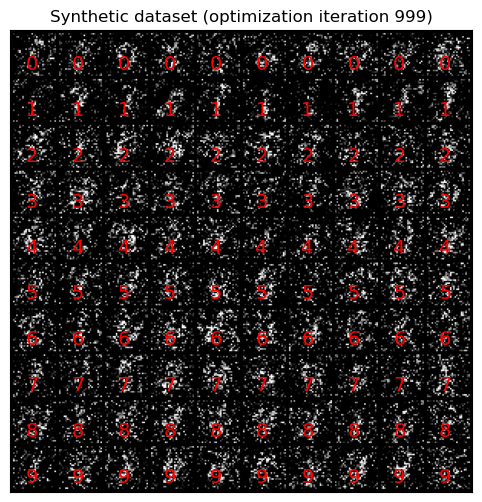

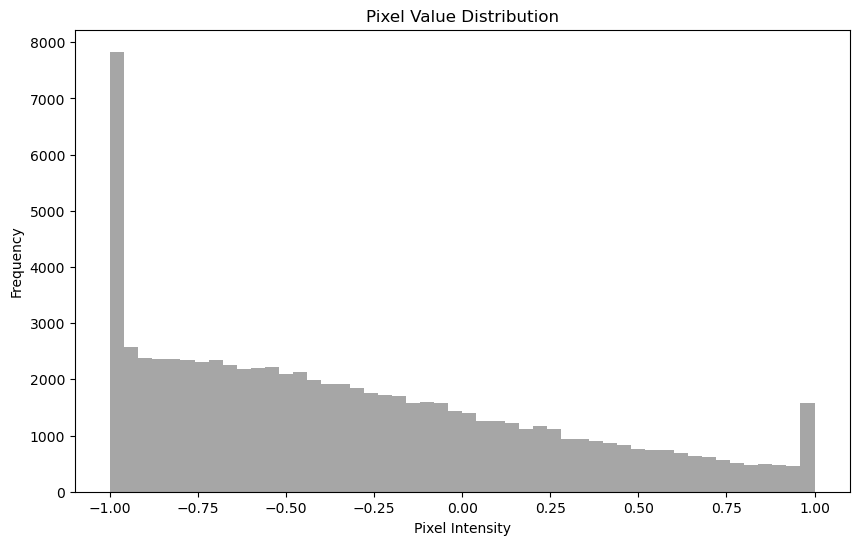

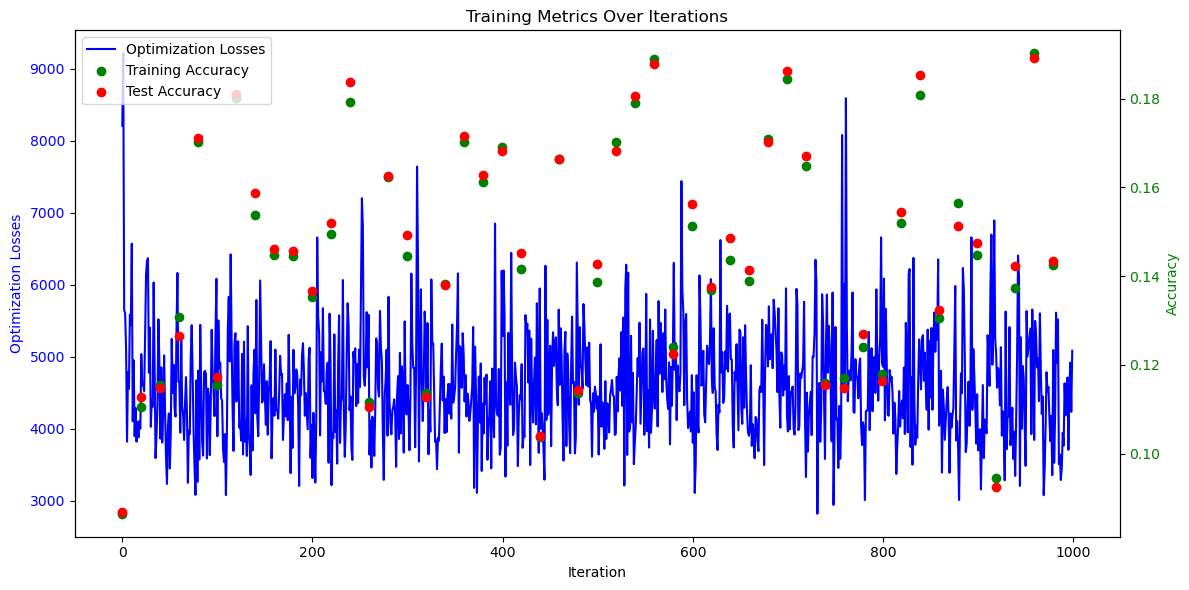

In [78]:
# load, distilled data, plot training curves

CHECKPOINT_PATH = "./saved_data/imgdd/gmatch_*.pth"

# Load the checkpoint
checkpoint = torch.load(glob(CHECKPOINT_PATH)[0], map_location=DEVICE)
dataset = checkpoint.get("dataset", "mnist")
method = checkpoint.get("method", "gmatch")
it = checkpoint['it']
img_syn = checkpoint['img_syn']
lab_syn = checkpoint['lab_syn']
optim_losses = checkpoint['optim_losses']
learned_lrs = checkpoint.get('learned_lrs', None)
eval_accs_train = checkpoint['eval_accs_train']
eval_accs_test = checkpoint['eval_accs_test']
init_weight_distr = checkpoint.get('init_weight_distr', 'kaiming')
fix_init_weights = checkpoint.get('fix_init_weights', False)

if dataset == "mnist":
    train_loader = mnist_train_loader
    test_loader = mnist_test_loader
    net_name = "lenet"
    pixel_mean, pixel_std = MNIST_MEAN, MNIST_STD
    num_classes = num_cls_mnist
else:
    raise NotImplementedError()

# Denormalize and move to CPU
images = denormalize(img_syn, pixel_mean, pixel_std).cpu()
# Create a grid of images
grid = make_grid(images, nrow=10)  # 10 images per row
fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f"Synthetic dataset (optimization iteration {it})")
ax.set_xticks([])
ax.set_yticks([])
# Display the grid of images
ax.imshow(grid.permute(1, 2, 0))
# Calculate the coordinates for annotations
grid_size = 10  # Number of images per row and column
height, width = images[0].shape[1], images[0].shape[2]
spacing = 2  # Spacing between images in the grid
for idx in range(len(lab_syn)):
    row = idx // grid_size
    col = idx % grid_size
    x = col * (width + spacing) + width / 2
    y = row * (height + spacing) + height
    # Add the text annotation
    ax.text(x, y, lab_syn[idx].item(), ha='center', va='bottom', fontsize=14, color='red')
plt.show()

# plot pixel distributions
# Convert img_syn to a numpy array if it's not already
img_syn_np = img_syn.cpu().numpy()
# Reshape the array to a 1D array for histogram plotting
pixels = img_syn_np.reshape(-1)
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(pixels, bins=50, color='gray', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
# Show the plot
plt.show()

# plot training curves
# Calculate the x-axis values for optim_losses and syn_lrs
x_values = range(len(optim_losses))  # This assumes optim_losses and syn_lrs have the same length
# Calculate the x-axis values for eval_accs_train and eval_accs_test
train_acc_x_values = [it * i / len(eval_accs_train) for i in range(len(eval_accs_train))]
test_acc_x_values = [it * i / len(eval_accs_test) for i in range(len(eval_accs_test))]
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot Losses on primary y-axis (ax1)
loss_line, = ax1.plot(x_values, optim_losses, label='Optimization Losses', color='blue')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Optimization Losses', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
# Create a second y-axis for Accuracies
ax2 = ax1.twinx()
train_acc_scatter = ax2.scatter(train_acc_x_values, eval_accs_train, label='Training Accuracy', color='green')
test_acc_scatter = ax2.scatter(test_acc_x_values, eval_accs_test, label='Test Accuracy', color='red')
ax2.set_ylabel('Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green')
# Create a third y-axis for Learning Rates, only if learned_lrs is not None
if learned_lrs is not None:
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
    lr_line, = ax3.plot(x_values, learned_lrs, label='Synthetic Learning Rates', color='orange')
    ax3.set_ylabel('Synthetic Learning Rates', color='orange')
    ax3.tick_params(axis='y', labelcolor='orange')
# Set title
plt.title("Training Metrics Over Iterations")
# Combine legends from all axes
lines = [loss_line, train_acc_scatter, test_acc_scatter]
if learned_lrs is not None:
    lines.append(lr_line)
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper left')
fig.tight_layout()  # Adjust the layout
plt.show()


Before training:
Eval acc (train): 0.1036
Eval acc (test): 0.1051


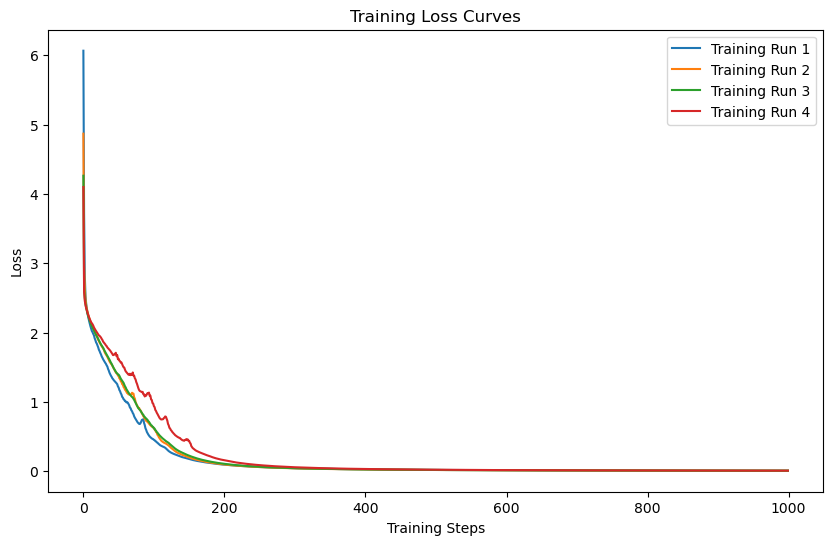

After training:
Eval acc (train): 0.2212
Eval acc (test): 0.2246


In [84]:
# evaluate distilled dataset on both training set and test set

NUM_SAMPLED_NETS_EVAL = 4

# sample a batch of models to eval on
sampled_nets = []
loss_fn = torch.nn.CrossEntropyLoss()
for j in range(NUM_SAMPLED_NETS_EVAL if not fix_init_weights else 1):
    if fix_init_weights:
        torch.random.manual_seed(42) # fixed seed
    else:
        torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
    net = get_net(net_name, init_weight_distr).to(DEVICE)
    sampled_nets.append(net)

# eval the sampled models without any training
train_accs = []
test_accs = []
print("Before training:")
for net in sampled_nets:
    # evaluate the models on both full train set and test set before training
    train_acc = overall_accuracy(net, train_loader)
    test_acc = overall_accuracy(net, test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
print(f"Eval acc (train): {sum(train_accs) / len(train_accs):.4f}")
print(f"Eval acc (test): {sum(test_accs) / len(test_accs):.4f}")

# train the models and plot curves (if exist)
if method == "vanilla":
    for net in sampled_nets:
        net.train()
        optimizer = torch.optim.SGD(net.parameters(), lr=learned_lrs[-1])
        # train the models on synthetic set
        pred_syn = net(img_syn.detach())
        loss_syn = loss_fn(pred_syn, lab_syn)
        optimizer.zero_grad()
        loss_syn.backward()
        optimizer.step()
elif method == "gmatch":
    train_loss_curves = []
    for net in sampled_nets:
        train_losses = []
        train_it = 1000
        lr = 1e-2
        optimizer = torch.optim.SGD(net.parameters(), lr=lr)
        for s in range(train_it):
            pred_syn = net(img_syn)
            loss_syn = criterion(pred_syn, lab_syn)
            train_losses.append(loss_syn.item())
            optimizer.zero_grad()
            loss_syn.backward()
            optimizer.step()
        train_loss_curves.append(train_losses)
    plt.figure(figsize=(10, 6))
    # Iterate over each set of loss values and plot them
    for i, losses in enumerate(train_loss_curves):
        plt.plot(losses, label=f'Training Run {i+1}')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Curves')
    plt.legend()
    plt.show()
else:
    raise NotImplementedError()

# eval the trained result models
train_accs = []
test_accs = []
print("After training:")
for net in sampled_nets:
    # evaluate the models on both full train set and test set after training
    train_acc = overall_accuracy(net, train_loader)
    test_acc = overall_accuracy(net, test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
print(f"Eval acc (train): {sum(train_accs) / len(train_accs):.4f}")
print(f"Eval acc (test): {sum(test_accs) / len(test_accs):.4f}")
